## In this notebook we create our model and evaluate it

**Model Steps:**

1. Run PCA on the preprocessed data

2. Use the elbow method to find a k value

3. Run kmeans with the dataframe created in the PCA step



# Set up and load data

In [1]:
# !pip install --quiet pyarrow polars

In [66]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
from umap import UMAP
from sklearn.cluster import KMeans, HDBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

RANDOM_STATE = 42

processed_users_path = "data/users_cleaned_df_encoded.parquet"
songs_path = "data/songs_df_full.csv"

C:\Users\User\anaconda3\envs\music-recommender\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# processed_users_path = "/content/drive/MyDrive/DSE/DSE 220 Final Project/Data/users_cleaned_df_encoded.parquet"
# songs_path = "/content/drive/MyDrive/DSE/DSE 220 Final Project/Data/songs_df_full.csv"
# from google.colab import drive
#
# drive.mount('/content/drive')

In [4]:
# Polars is faster at loading large datasets
users_polars_df = pl.read_parquet(processed_users_path)

In [5]:
# This conversion can take 51s on regular ram, 21 seconds on high ram mode
users_df = users_polars_df.to_pandas(use_pyarrow_extension_array=True)

In [6]:
# Drop all one hot encoded fav artist columns (takes too long to run)
users_df = users_df[users_df.columns.drop(list(users_df.filter(regex='fav_artist_')))]
len(users_df)


In [8]:
# Load the songs data to use it in the playlist generation at the end
# songs_df = pd.read_csv(songs_path)
# len(songs_df)

# PCA
Run PCA and capture at least 90% of the variance.

In [10]:
# Want to keep at least 90% of the variance
transformer = PCA(n_components=0.9, random_state=RANDOM_STATE)

In [11]:
# Drop user_id as it will not have relevance for clustering
X = users_df.drop(columns=['user_id'])

In [12]:
X_pca = transformer.fit_transform(X)

In [13]:
# Create new columns for each of the components
num_cols = X_pca.shape[1]
X_pca_df = pd.DataFrame(
    X_pca,
    columns=[f'PC{i + 1}' for i in range(num_cols)]
)
X_pca_df.head()

,PC1,PC2,PC3,PC4,PC5
0,-2.952348,0.509648,1.584415,-2.667762,-0.216009
1,-2.057276,0.634912,0.417394,0.810487,-0.203877
2,-2.920652,0.301855,-2.018689,-3.862385,0.149771
3,-1.843526,-0.514891,-0.190530,1.023504,0.324173
4,-1.472321,-0.725381,1.100922,0.722372,0.599554


In [14]:
print("Explained variance ratio by each component:", transformer.explained_variance_ratio_)
print("Total variance captured:", np.sum(transformer.explained_variance_ratio_))

Explained variance ratio by each component: [0.48401599 0.29105516 0.04838967 0.04391104 0.0337296 ]
Total variance captured: 0.901101457150188


# Elbow method
Use elbow method and a plot to see how many clusters we should use.

In [15]:
n_clusters = 30  # how many clusters to test
k_values = range(1, n_clusters + 1)
inertia_values = []
# store the number of data points within each cluster for every k tested
kmeans_comp_arr = np.zeros((n_clusters, n_clusters))

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init='auto')
    kmeans_fitted = kmeans.fit(X_pca_df)
    inertia_values.append(kmeans.inertia_)
    # unique cluster labels assigned to each data point, counts points in cluster
    cluster_id, counts = np.unique(kmeans_fitted.labels_, return_counts=True)
    for i in range(len(cluster_id)):
        kmeans_comp_arr[k - 1, cluster_id[i]] = counts[i]

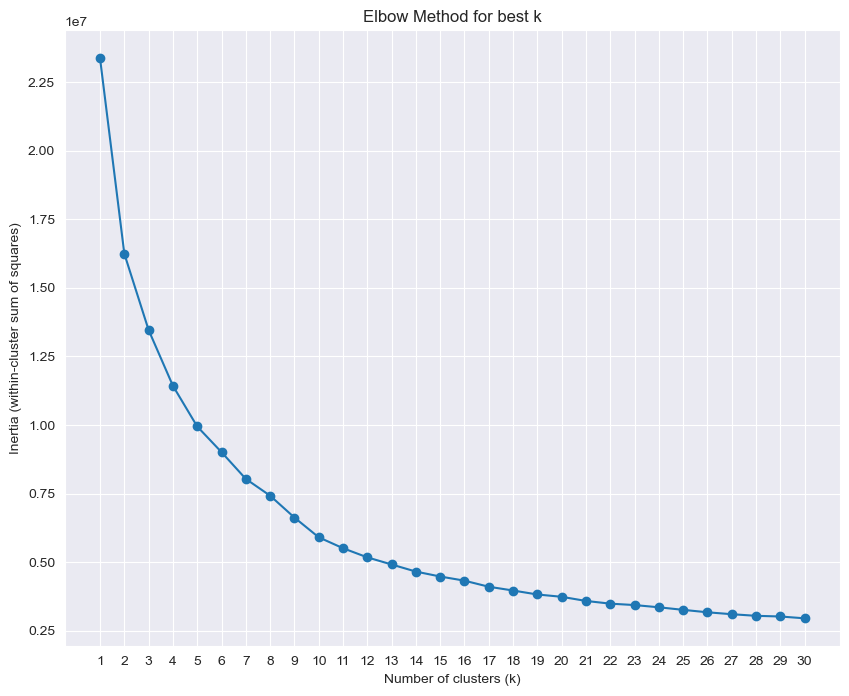

In [16]:
# Plot the elbow
plt.figure(figsize=(10, 8))
plt.plot(k_values, inertia_values, marker='o')
plt.xticks(k_values)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (within-cluster sum of squares)')
plt.title('Elbow Method for best k')
plt.grid(True)
plt.show()

In [17]:
kmeans_comp_df = pd.DataFrame(
    kmeans_comp_arr,
    index=k_values,
    columns=[f'Cluster {i}' for i in range(n_clusters)]
)

print("Distribution of data points per cluster for each k (rows = k, columns = cluster ID):")
display(kmeans_comp_df.head(10))

Distribution of data points per cluster for each k (rows = k, columns = cluster ID):


,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9,...,Cluster 20,Cluster 21,Cluster 22,Cluster 23,Cluster 24,Cluster 25,Cluster 26,Cluster 27,Cluster 28,Cluster 29
1,933431.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,822765.0,110666.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,815617.0,86117.0,31697.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,181603.0,25553.0,21013.0,705262.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,46763.0,156766.0,938.0,705911.0,23053.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,238543.0,73359.0,21134.0,589024.0,11238.0,133.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,194148.0,55859.0,4251.0,608470.0,9036.0,53.0,61614.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,170183.0,9075.0,1277.0,584549.0,17689.0,95072.0,39.0,55547.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,166226.0,8988.0,2063.0,578558.0,21503.0,101590.0,81.0,54421.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,145846.0,8042.0,2032.0,487816.0,20446.0,93962.0,81.0,47591.0,1.0,127614.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


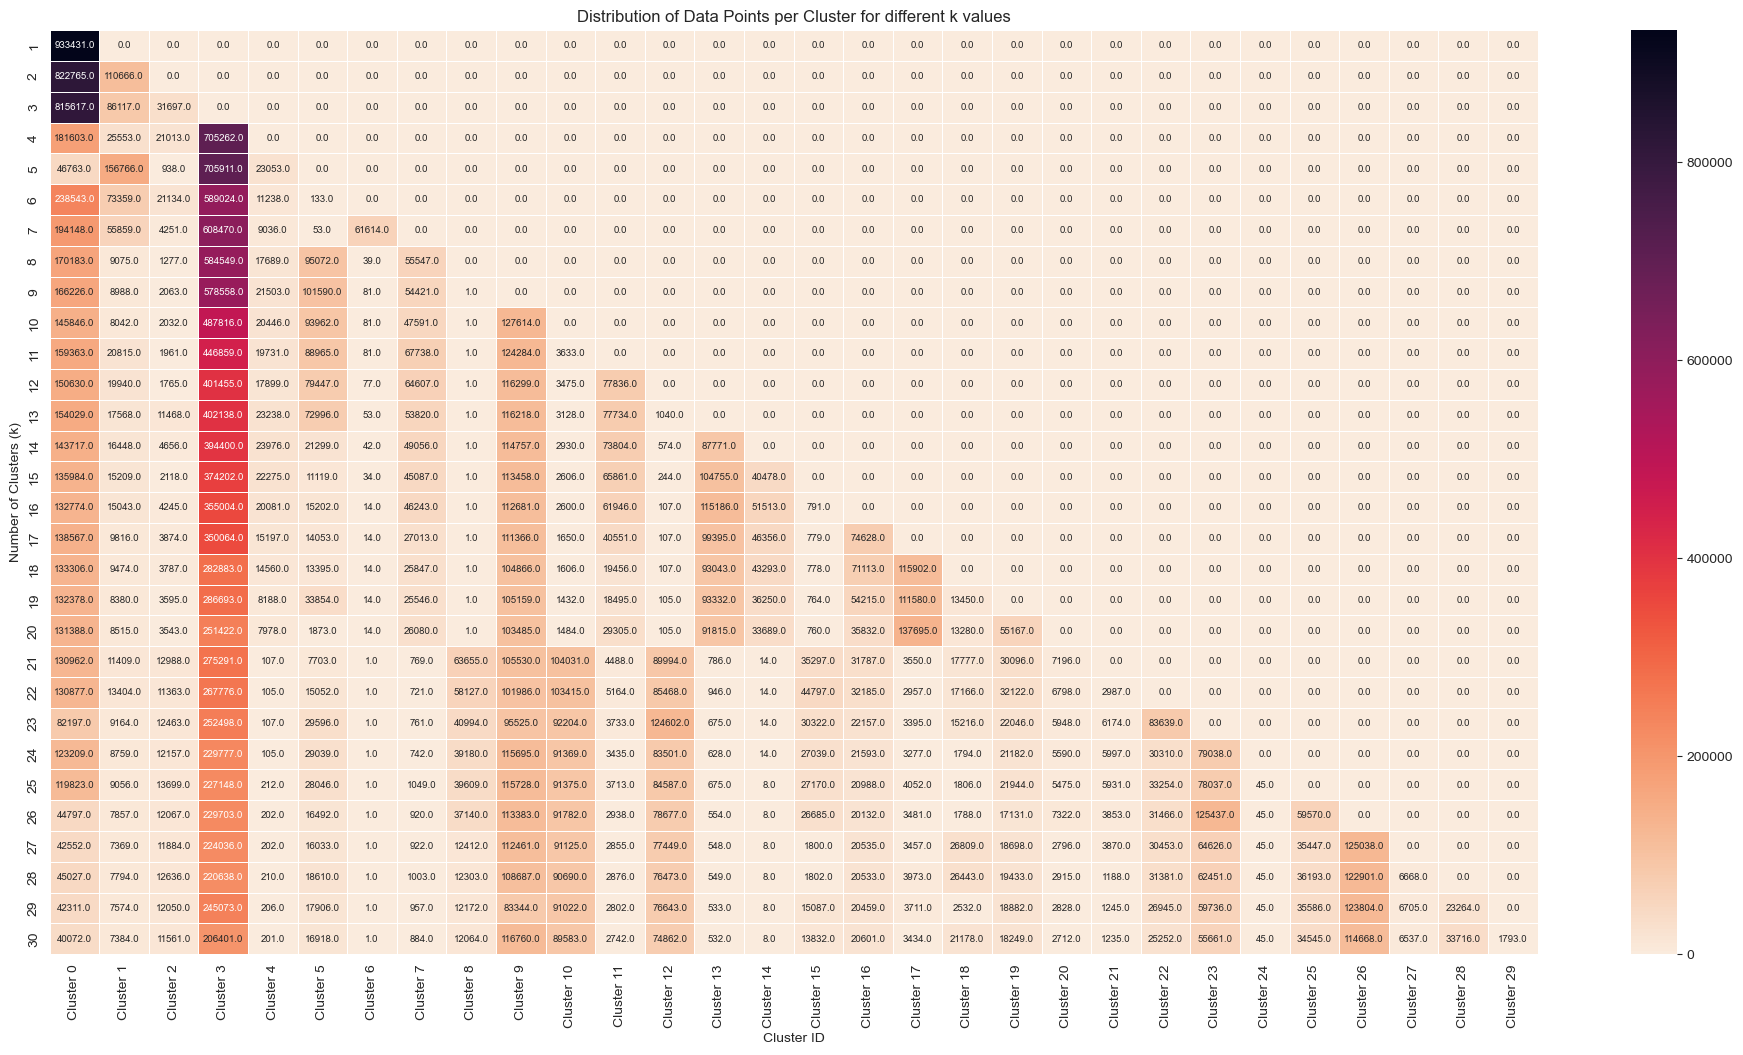

In [18]:
plt.figure(figsize=(24, 12))
sns.heatmap(kmeans_comp_df,
            annot=True,
            fmt='.1f',
            cmap='rocket_r',
            annot_kws={'fontsize': 7},
            linewidths=0.5
            )
plt.title('Distribution of Data Points per Cluster for different k values')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Clusters (k)')
plt.show()

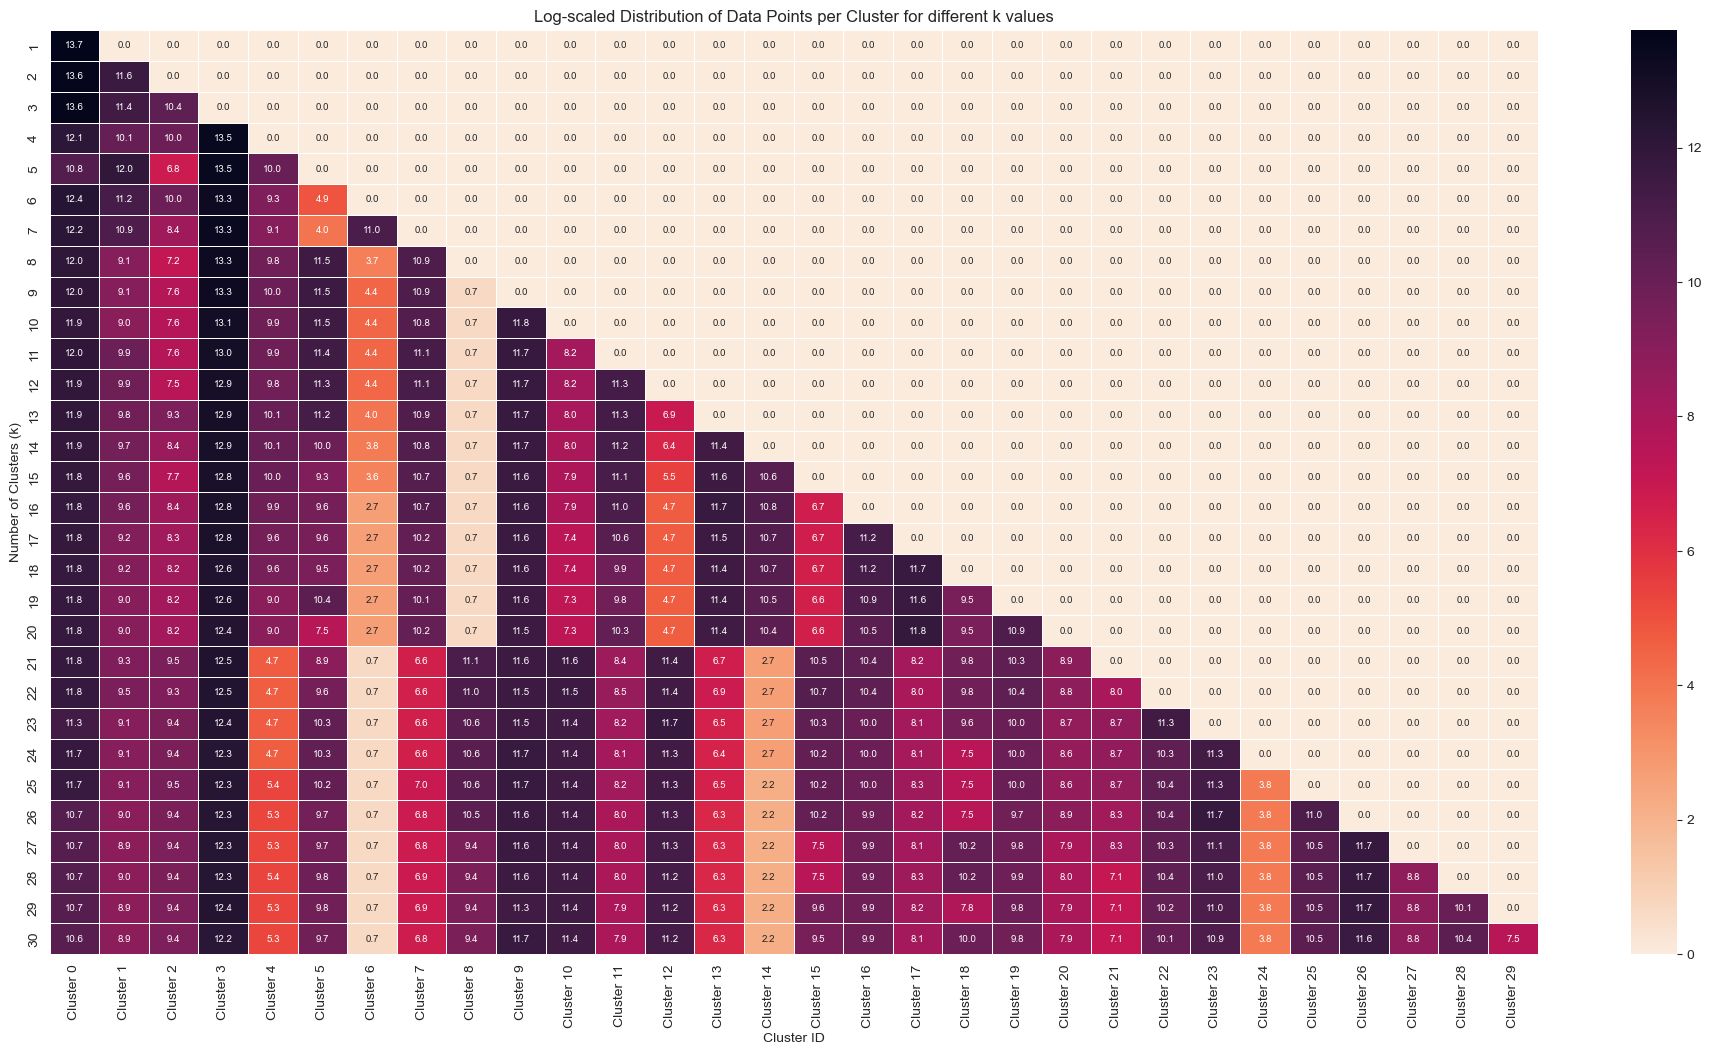

In [19]:
plt.figure(figsize=(24, 12))
sns.heatmap(np.log1p(kmeans_comp_df), annot=True, fmt='.1f', cmap='rocket_r', annot_kws={'fontsize': 7}, linewidths=0.5)
plt.title('Log-scaled Distribution of Data Points per Cluster for different k values')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Clusters (k)')
plt.show()

# Model Creation

## K Means Clustering

In [20]:
# Based on the elbow, we observe a leveling out at k=9
k_num_clusters = 26

In [21]:
kmeans = KMeans(n_clusters=k_num_clusters, random_state=RANDOM_STATE, n_init='auto')
kmeans_fitted = kmeans.fit(X_pca_df)
inertia_values.append(kmeans.inertia_)
np.unique(kmeans_fitted.labels_, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25], dtype=int32),
 array([ 44797,   7857,  12067, 229703,    202,  16492,      1,    920,
         37140, 113383,  91782,   2938,  78677,    554,      8,  26685,
         20132,   3481,   1788,  17131,   7322,   3853,  31466, 125437,
            45,  59570]))

## HDBSCAN
Density based clustering

*   We noticed in a previous milestone that we had clusters with very few data points, so we wanted to try density based clustering to remedy this.
*   DBSCAN groups points that are closely packed together (many nearby neighbors)
*   Outliers in low-desnity regions are marked



In [73]:
# hdbscan = O(n^2) = takes too long to run on full dataset
users_df_hdbscan = users_df.sample(n=100000, random_state=RANDOM_STATE)
X_hdbscan = users_df_hdbscan.drop(columns=['user_id'])

In [71]:
# works better than pca for hdbscan
X_umap = UMAP(
    n_components=15,
    n_neighbors=30,
    min_dist=0.0,
    # random_state=RANDOM_STATE
).fit_transform(X_hdbscan)

C:\Users\User\anaconda3\envs\music-recommender\Lib\site-packages\umap\spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


In [81]:
print(X_umap.shape)

(100000, 15)


In [72]:
print("Starting HDBSCAN...")
start_time = time.time()

labels = HDBSCAN(
    min_cluster_size=20,   # start smaller in high-dim
    min_samples=10,        # controls how strict "core" points are
    n_jobs=-1
).fit_predict(X_umap)

end_time = time.time()
print(f"HDBSCAN completed in {end_time - start_time:.2f} seconds")

Starting HDBSCAN...
HDBSCAN completed in 60.26 seconds


In [74]:
users_df_hdbscan["hdb_cluster"] = labels

In [75]:
users_df_hdbscan["hdb_cluster"].value_counts()

hdb_cluster
-1      36362
 42      8293
 14      3118
 21      2604
 105     2211
        ...  
 97        20
 225       20
 157       20
 116       20
 106       20
Name: count, Length: 471, dtype: int64

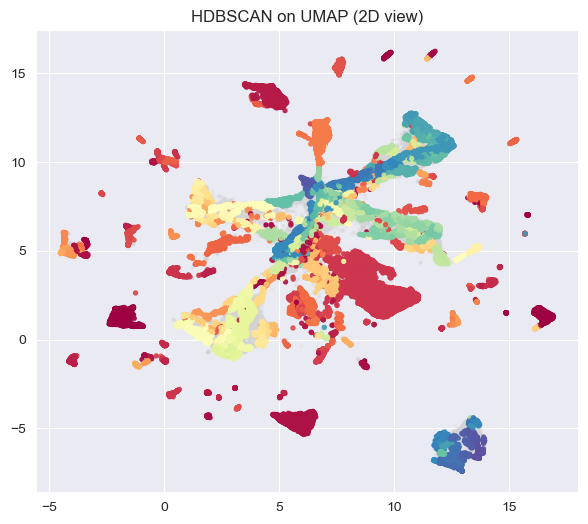

In [83]:
# ai slop
X_umap_2d = UMAP(
    n_components=2,
    n_neighbors=30,
    min_dist=0.0,
).fit_transform(X_hdbscan)
plot_df = pd.DataFrame(X_umap_2d, columns=["UMAP1", "UMAP2"])
plot_df["hdb_cluster"] = labels

noise = plot_df[plot_df["hdb_cluster"] == -1]
clusters = plot_df[plot_df["hdb_cluster"] != -1]

plt.figure(figsize=(7,6))

# noise first, light gray
plt.scatter(
    noise["UMAP1"], noise["UMAP2"],
    c="lightgray", s=2, alpha=0.15
)

# clusters on top
plt.scatter(
    clusters["UMAP1"], clusters["UMAP2"],
    c=clusters["hdb_cluster"], cmap="Spectral",
    s=8, alpha=0.9
)

plt.title("HDBSCAN on UMAP (2D view)")
plt.show()

In [25]:
fdfdf

NameError: name 'fdfdf' is not defined

# Model Evaluation

## DBSCAN

In [ ]:
# Compute Silhouette Score to measure cluster similarity
# It's too costly with the whole dataset so we sample with 50k
# sample = np.random.choice(len(X_pca_df), size=50000, replace=False)
# score = silhouette_score(X_pca_df.iloc[sample], dbscan_fitted.labels_[sample])
# print("Silhouette Score (sample):", score)

In [ ]:
# For PCA Plots

# users_df_dbscan_clusters = X_pca_df.copy()
# users_df_dbscan_clusters['cluster_id'] = dbscan_fitted.labels_
# users_df_dbscan_clusters['user_id'] = users_df_genre['user_id']

In [ ]:
# users_df_dbscan_clusters['cluster_id'].value_counts()

 ## K Means

In [ ]:
# Compute Silhouette Score to measure cluster similarity
# It's too costly with the whole dataset so we sample with 50k
sample = np.random.choice(len(X_pca_df), size=100000, replace=False)
score = silhouette_score(X_pca_df.iloc[sample], kmeans_fitted.labels_[sample])
print("Silhouette Score (sample):", score)

In [ ]:
# For PCA Plots
users_columns_pca = X_pca_df.columns
users_centroids_pca = kmeans_fitted.cluster_centers_
users_kmeans_centroids_df = pd.DataFrame(columns=users_columns_pca, data=users_centroids_pca)
users_kmeans_centroids_df['cluster_id'] = users_kmeans_centroids_df.index

users_df_kmeans_clusters = X_pca_df.copy()
users_df_kmeans_clusters['cluster_id'] = kmeans_fitted.labels_
users_df_kmeans_clusters['user_id'] = users_df_genre['user_id']

In [ ]:
users_kmeans_centroids_df

In [ ]:
# For visualizing using original features
users_df_clusters_orig = users_df_genre.copy()
users_df_clusters_orig['cluster_id'] = kmeans_fitted.labels_
users_df_clusters_orig['user_id'] = users_df_genre['user_id']

In [ ]:
users_df_kmeans_clusters['cluster_id'].value_counts().sort_index()

In [ ]:
# How are clusters distinguished across different PC features
sns.pairplot(
    hue='cluster_id',
    palette='Set2',
    data=users_df_kmeans_clusters.sample(n=10000, random_state=RANDOM_STATE)
)

In [ ]:
# Inspect a designated pc space more closely (look at pairplots for general overview)
# Also shows the centroids
variable_pairs = ['PC4', 'PC5']

#plotting the results
sns.scatterplot(
    x=variable_pairs[0],
    y=variable_pairs[1],
    hue='cluster_id',
    palette='Set1',
    size=1, alpha=0.7,
    data=users_df_kmeans_clusters.sample(n=100000, random_state=RANDOM_STATE)
)

sns.scatterplot(
    x=variable_pairs[0],
    y=variable_pairs[1],
    hue='cluster_id',
    palette='Set1',
    markers=1000,
    alpha=1,
    edgecolor="black",
    data=users_kmeans_centroids_df,
    legend=False
)
plt.show()

In [ ]:
# To show that our current model is not separating just on play count and play time
# We can see this because it is not neatly separated on these 2 features alone (like it was with just numerical values)
variable_pairs = ['total_play_count', 'unqiue_artist_count']
# Plotting the results
sns.scatterplot(
    x=variable_pairs[0],
    y=variable_pairs[1],
    hue='cluster_id',
    palette='Set1',
    size=1, alpha=0.7,
    data=users_df_clusters_orig.sample(n=100000, random_state=RANDOM_STATE)
)
plt.show()

# Playlist Generation

In [ ]:
u_id = users_df_kmeans_clusters[users_df_kmeans_clusters['cluster_id'] == 8]['user_id'].values[0]
u_id

In [ ]:
songs_df[songs_df['user_id'] == u_id]

In [ ]:
users_df[users_df['user_id'] == u_id]


In [ ]:
users_df['total_play_time'].hist()

In [ ]:
users_songs_clusters = pd.merge(songs_df, users_df_kmeans_clusters, on='user_id')
users_songs_clusters = users_songs_clusters.drop(
    columns=["track_id", "artist_id", "artist_mbid", "shs_perf", "shs_work",
             "track_7digitalid", 'PC1', 'PC2', 'PC3', 'PC4', 'PC5'])  #, 'PC6'])

In [ ]:
users_songs_clusters.head(5)

In [ ]:
# Group and sort in descending order
usc = users_songs_clusters.groupby(['cluster_id', 'song_id'])['plays'].count().sort_values(ascending=False)

In [ ]:
# Top 10 songs per cluster
top_10_per_cluster = usc.groupby(level='cluster_id').head(10)

In [ ]:
# Convert the top_10_per_cluster Series to a DataFrame
top_10_df = top_10_per_cluster.reset_index()
# Select relevant columns from users_songs_clusters
song_details_cols = ['cluster_id', 'song_id', 'title', 'release', 'artist_name', 'duration', 'artist_familiarity',
                     'artist_hotttnesss', 'tot_track_time']
users_songs_details = users_songs_clusters[song_details_cols]
# Merge with users_songs_details to get song details
top_songs_details = pd.merge(top_10_df, users_songs_details, on=['cluster_id', 'song_id'], how='left')
# Drop duplicate rows that might arise from the merge (keeping the first occurrence)
top_songs_details = top_songs_details.drop_duplicates(subset=['cluster_id', 'song_id'], keep='first')
# Display the resulting DataFrame
display(top_songs_details.head())

In [ ]:
users_songs_clusters['cluster_id'].value_counts()


In [ ]:
cluster_totals = users_songs_clusters.groupby('cluster_id').agg(
    total_plays=('plays', 'sum'),
    total_track_time=('tot_track_time', 'sum')
)

unique_users_per_cluster = users_df_kmeans_clusters.groupby('cluster_id')['user_id'].nunique()
unique_users_per_cluster = users_df_kmeans_clusters.groupby('cluster_id')['user_id'].nunique()

avg_plays_per_user = cluster_totals['total_plays'] / unique_users_per_cluster

avg_tot_track_time_per_user = cluster_totals['total_track_time'] / unique_users_per_cluster

cluster_summary_df = pd.DataFrame({
    'unique_users': unique_users_per_cluster,
    'total_plays': cluster_totals['total_plays'],
    'total_track_time': cluster_totals['total_track_time'],
    'avg_plays_per_user': avg_plays_per_user,
    'avg_total_track_time_per_user': avg_tot_track_time_per_user
})
display(cluster_summary_df)

In [ ]:
users

In [ ]:
cluster_summary_df_plot = cluster_summary_df.reset_index()
sns.pairplot(cluster_summary_df_plot, hue='cluster_id', palette='Set2', corner=True, diag_kind='kde')
plt.suptitle('Pairplot of Cluster Summary Metrics', y=1.02)
plt.show()